In [99]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.integrate import odeint
%matplotlib inline 
#Plot shows up inside browser format

# Inverted Pendulum - System Modeling
---
<img src="images/img2.jpg">
   
## Problem Set-Up & Design Requirements
***
   The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the altitude control of a booster rocket at takeoff.
   In this case, we'll consider a two dimensional problem where the pendulum is constrained to move in the vertical plane shown in the figure below. For this system, the control input is the force **F** that moves the cart horizontally and the outputs are the angular position of the pendulum $\theta$ and the horizontal position of the cart ***x***.
   
### For this model, we'll assume the following quantities:

In [170]:
M=.5 #Mass of the cart (kg)
m=.2 #Mass of pendulum (kg)
b=.1 #Coefficient of friction for cart (N/m/sec)
l=.3 #Length to pendulum center of mass (m)
I=.006 #Mass moment of intertia of pendulum (kgm^2)
g=9.81 #Acceleration of Gravity (m/s/s)

   For the PID (Proportional Intergration Derivative Controller), root locus, and frequency response sections of this problem, we will be interested only in the control of the pendulum's position. This is because the techniques in these sections are best-suited for single-input, single-output (SISO) systems. Therefore, none of the design criteria deal with the cart's position. We will, however, investigate the controller's effect on the cart's position after the controller has been designed. For these sections, we will design a controller to restore the pendulum to a vertically upward position after it has experienced an impulsive "bump" to the cart. Specifically, the design criteria are that the pendulum return to its upright position within 5 seconds and that the pendulum never more than 0.05 radians awary from vertical after  being disturbed by an impulse of magnitude 1 Nsec. The pendulum will initially begin in the vertically upward equilibrium, $\theta = \pi$.

   In summary, the design requirements of the system are:
  - Settling time for $\theta$ of less than 5 seconds.
  - Pendulum angle $\theta$ never more than 0.05 radians from the vertical
  
Employing state-space design techniques, we are more readily able to address a multi-output system. In our case, the inverted pendulum system is single-input, multi-output (SIMO). Therefore, for the state-space section of the Inverted Pendulum example, we will attempt to control both the pendulum's angle and the cart's positoin. To make  the design more challenging in this section, we will command a 0.2-meter step in the cart's desired position. Under these conditions, it is desired that the cart achieve its commanded position within 5 seconds and have a rise time under 0.5 seconds. It is also desired that the pendulum settle to its vertical position in under 5 seconds, and further, that the pendulum angle not travel more than 20 degrees (0.35 radians) away from the vertically upward position.

   In summary, the design requirements for the inverted pendulum state-space example are:
  - Settling time for **x** and $\theta$ of less than 5 seconds.
  - Rise time form **x** of less than 0.5 seconds
  - Pendulum angle $\theta$ never more than 20 degrees (0.35 radians) from the vertical
  - Steady-state error of less the 2% for **x** and $\theta$

## Force Analysis & System Equations

Below are the FBDs of the two elements of the inverted pendulum system:
<img src="images/img3.jpg">
Summing the forces in the FBD in the x-direction (horizontal), you obtian the following equation:

\begin{align}
M\ddot{x}+b\dot{x}+N=F
\end{align}

Note that you can also sum the force in the y-direction (vertically), but no useful information would be gained.

Summing the forces in the FBD of the pendulum in the horizontal x-direction, you get the following expression for the reaction force **N**.

\begin{align}
N=m\ddot{x}+ml\ddot{\theta}cos(\theta)-ml\dot{\theta}^2sin(\theta)
\end{align}

If you substitute this equation into the first equation, you get one of the two governing equations for this system:

\begin{align}
(M+m)\ddot{x}+b\dot{x}+ml\ddot{\theta}cos(\theta)-ml\dot{\theta}^2sin(\theta)=F
\end{align}

To get the second equation of motion for this system, sum the forces perpendicular to the pendulum. Solving the system along this axis greatly simplifies the mathematics. You should get the following equation:

\begin{align}
Psin(\theta)+Ncos(\theta)-mgsin(\theta)=ml\ddot{\theta}+m\ddot{x}cos(\theta)
\end{align}

To get ride of the **P** and **N** terms in the equation above, sum the moments about the centroid of the pendulum to get the following equation.

\begin{align}
-Plsin(\theta)-Nlcos(\theta)=I\ddot{\theta}
\end{align}

Combining these last two expressions, you get the second governing expression:

\begin{align}
(I+ml^2)\ddot{\theta}+mglsin(\theta)=-ml\ddot{\theta}cos(\theta)
\end{align}

Since the analysis and control design techniques we will be employing in this example apply only to linear systems, this set of equations needs to be linearized. Sepcifically, we will linearize the equations about the vertically upward equillibrium positions, $\theta=\pi$, and we will assume that the system stays within a small neighborhood of this equillbrium. This assumption should be reasonably valid since under control we desire that the pendulum not deviate more than 20 degrees from the vertically upward position. Let $\phi$ represent the deviation of the pendulum's position from equilibrium, that is, $\theta=\pi+\phi$. Again presuming a small deviation ($\phi$) from equilibrium, we can use the following small angle approximations of the nonlinear functions in our system equations:

\begin{align}
cos(\theta)=cos(\pi + \phi) \approx -1
\newline
sin(\theta)=sin(\pi + \phi) \approx -\phi
\newline
\dot{\theta}^2=\dot{\phi}^2 \approx 0
 \end{align}
 
 ### 1. Transfer Function
 
 To obtain the transfer functions of the linearized system equations, we must first take the Laplace transform of the system equations assuming zero initial conditions. The resulting Laplace transforms are shown below:

\begin{align}
(I+ml^2)\Phi(s)s^2-mgl\Phi(s)=mlX(s)s^2
\newline
(M+m)X(s)s^2+bX(s)s-ml\Phi(s)s^2=U(s)
\end{align}

Recall that a transfer function represents the releationship between a single inputs and a single output at a time. To find our first transfer function for the output $\Phi(s)$ and an input of **U(s)** we need to eliminate **X(s)** from the above equations. Solve the first equation for **X(s)**.

\begin{align}
X(s)=[\frac{I+ml^2}{ml}-\frac{g}{s^2}]\Phi(s)
\end{align}

Then substitute the above into the second equation.

\begin{align}
(M+m)[\frac{I+ml^2}{ml}-\frac{g}{s^2}]\Phi(s)s^2+b[\frac{I+ml^2}{ml}-\frac{g}{s^2}]\Phi(s)s-ml\Phi(s)s^2=U(s)
\end{align}

Rearranging, the transfer function is then the following:

\begin{align}
\frac{\Phi(s)}{U(s)}=\frac{\frac{ml}{q}s^2}{s^4+\frac{b(I+ml^2)}{q}s^3-\frac{(M+m)mgl}{q}s^2-\frac{bmgl}{q}s}
\end{align}

where,

\begin{align}
q=[(M+m)(I+ml^2)-(ml)^2]
\end{align}

From the transfer function above it can be seen that there is both a pole and a zero at the origin. These can be canceled and the transfer function becomes the following:

\begin{align}
P_{pend}(s)=\frac{\Phi(s)}{U(s)}=\frac{\frac{ml}{q}s}{s^3+\frac{b(I+ml^2)}{q}s^2-\frac{(M+m)mgl}{q}s-\frac{bmgl}{q}} && [\frac{rad}{N}]
\end{align}

### 2. State-Space

The linearized equations of motion from above can also be represented in state-space form if they are arranged into a series of first order differential equations. Since the equations are linear, they can then be put into the standard matrix form shown below.
\begin{align}
\begin{bmatrix}
\dot{x} \\
\ddot{x} \\
\dot{\phi} \\
\ddot{\phi}
\end{bmatrix}
=
\begin{bmatrix}
0 && 1 && 0 && 0 \\
0 && \frac{-(I+ml^2)b}{I(M+m)+Mml^2} && \frac{m^2gl^2}{I(M+m)+Mml^2} && 0 \\
0 && 0 && 0 && 1 \\
0 && \frac{-mlb}{I(M+m)+Mml^2} && \frac{mgl(M+m)}{I(M+m)+Mml^2} && 0
\end{bmatrix}
\begin{bmatrix}
x \\
\dot{x} \\
\phi \\
\dot{\phi} 
\end{bmatrix}
+
\begin{bmatrix}
0 \\
\frac{I+ml^2}{I(M+m)+Mml^2} \\
0 \\
\frac{ml}{I(M+m)+Mml^2}
\end{bmatrix}
u
\newline
\end{align}
\begin{align}
\newline
y =
\begin{bmatrix}
1 && 0 && 0 && 0  \\
0 && 0 && 1 && 0
\end{bmatrix}
\begin{bmatrix}
x \\
\dot{x} \\
\phi \\
\dot{\phi} 
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 
0
\end{bmatrix}
u
\end{align}


The **C** matrix has 2 rows because both the cart's position and the pendulum's position are part of the output. Specifically, the cart's position is the first element of the output **y** and the pendulum's deviations from its equilibrium position is the second element of **y**.

### Modeling
---
**State-Space Representation:**

The system is an unstable system.


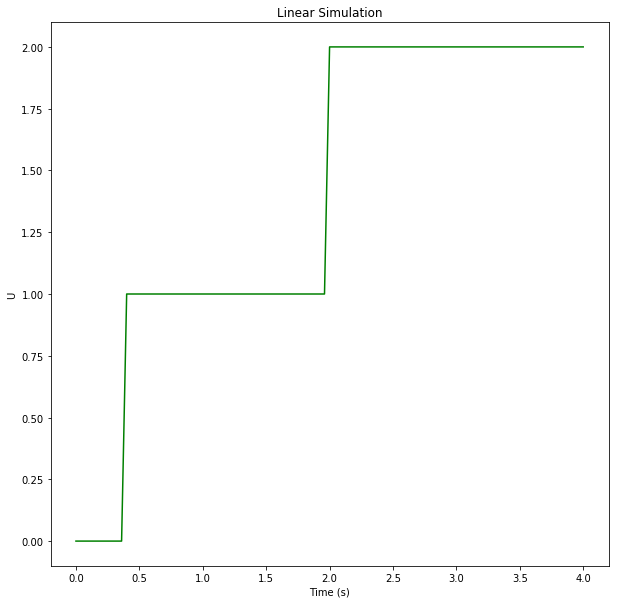

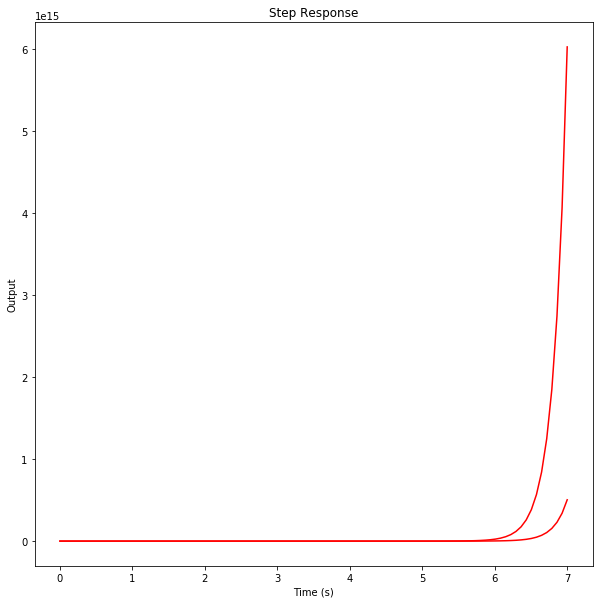

In [169]:
#Standard State-Space Form: [x'=Ax+bu ; y=cx+du]
A=[[0,1,0,0],[0,-(I+m*l**2)*b/(I*(M+m)+M*m*l**2),(m**2*g*l**2)/(I*(M+m)+M*m*l**2),0],[0,0,0,1],[0,-(m*l*b)/(I*(M+m)+M*m*l**2),(m*g*l*(M+m))/(I*(M+m)+M*m*l**2),0]] #4x4
B=[[0],[(I+m*l**2)/(I*(M+m)+M*m*l**2)],[0],[(m*l)/(I*(M+m)+M*m*l**2)]] #4x1
C=[[1,0,0,0],[0,0,1,0]] #2x4
D=[[0],[0]]


#State-Space System Equations
system=signal.StateSpace(A,B,C,D)

#Step Response of System 
tstep,ystep=signal.step(system)

#Lsim = Linear Simulation
t=np.linspace(0,4,101)
u=np.zeros(len(t))
u[10:50]=1
u[50:]=2
t1,y1,x1=signal.lsim(system,u,t)

#Plot
#Linear Simulation
plt.figure(figsize=(10,10))
plt.title('Linear Simulation')
plt.xlabel('Time (s)')
plt.ylabel('U')
plt.plot(t,u,c='green',label='Linear Simulation')

#Step Response
plt.figure(figsize=(10,10))
plt.plot(tstep,ystep,c='red',label='Step Response')
plt.title('Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Output')

#Determining Stability of the system: if the real part eigen values of A are all negative the system is stable.
eigVals=np.linalg.eig(A)[0]
j=0
i=0
while j<1:
    if eigVals[i]>0:
        print('The system is an unstable system.')
        j=j+1
    elif i==len(eigVals)-1:
        print('The system is a stable system.')
        j=j+1
    else:
        i=i+1

It is clear from the results of the eigen values of Matrix A and the open-loop impulse response of the system that the system is unstable in open loop.

Some sort of control will need to be designed to improve the response of the system. 

### 1. Transfer Function
We can represent the transfer functions derived above for the inverted pendulum system employing the following comands. Recall that the two transfer functions are only valid for small values of the angle $\phi$, which is the angular displacement of the pendulum from the vertically upward polstion. Also, the absolute pendulum angle $\theta$ is equal to $\pi + \phi$.

In [171]:
#Continuous-time transfer function representation


#Open Loop Transfer Functions of Model
#rad/N
def pCart(s):
    return (((I+m*l**2)/q)*s**2 - (m*g*l/q))/(s**4 + (b*(I + m*l**2))*s**3/q - ((M + m)*m*g*l)*s**2/q - b*m*g*l*s/q)
#m/N
def pPend(s):
    return (m*l*s/q)/(s**3 + (b*(I + m*l**2))*s**2/q - ((M + m)*m*g*l)*s/q - b*m*g*l/q)

#where:
q=(M+m)*(I+m*l**2)-(m*l)**2

  Considering the response of the pendulum to a 1-Nsec impulse applied to the cart, the design requirements for the pendulum are (Control Law for Pendulum):
   - Settling time for $\theta$ of less than 5 seconds
   - Pendulum angle $\theta$ never morre than 0.05 radians from the vertical
  

Additionally, the requirements for the response of the system to a 0.2-meter step command in cart position are (Control Law for Cart):
- Settling time for x and $\theta$ of less than 5 seconds
- Rise time for x of less than 0.5 seconds
- Pendulum angle $\phi$ never more than 20 degrees (0.35 radians) from the vertical

## PID Controller Design


In [ ]:
# TO DO WILL BE DONE SOON HOSS ~